In [1]:
%load_ext autoreload
%autoreload 1

import glob
import numpy as np
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib widget

processed_directory = './data/processed_mats/*.mat'
acceptable_call_labels = ['Call', 'Stimulus', 'male_calls']  # any stimulus_trials containing call types NOT in this list are excluded (this includes unlabeled, which are stored as 'USV'!!)

files = [f for f in glob.glob(processed_directory)]
files


['./data/processed_mats/or14pu27-d1-2024329115821-Block1-PROCESSED.mat',
 './data/processed_mats/pk81rd39-d2-20240403122107-Block1-PROCESSED.mat',
 './data/processed_mats/or13pu25_d2_20242141206-Block1-PROCESSED.mat',
 './data/processed_mats/pk44rd13-d1-20243271268-Block1-PROCESSED.mat',
 './data/processed_mats/pk81rd39-d1-20244212128-Block1-PROCESSED.mat',
 './data/processed_mats/pk63rd15-d1-2024312115724-Block1-PROCESSED.mat',
 './data/processed_mats/or54rd45-d1-20240423131059-Block1-PROCESSED.mat',
 './data/processed_mats/gr18bu69-d1-20240418115824-Block1-PROCESSED.mat',
 './data/processed_mats/or54rd45-d2-20240424115748-Block1-PROCESSED.mat',
 './data/processed_mats/gr18bu69-d2-20240419122439-Block1-PROCESSED.mat',
 './data/processed_mats/pk44rd13-d2-2024328121232-Block1-PROCESSED.mat',
 './data/processed_mats/or14pu27-d2-2024330115149-Block1-PROCESSED.mat',
 './data/processed_mats/or13pu25_d120242131204-Block1-PROCESSED.mat',
 './data/processed_mats/pk63rd15-d2-202431311573-Block1

In [2]:
%aimport utils.deepsqueak
from utils.deepsqueak import call_mat_stim_trial_loader, multi_index_from_dict

df = pd.DataFrame()

call_types_all = pd.DataFrame()
rejected_trials_all = pd.DataFrame()

for file in files:
    calls_df, stim_trials, rejected_trials, file_info, call_types = call_mat_stim_trial_loader(file, acceptable_call_labels=['Call', 'Stimulus'], verbose=False)

    multi_index_info = OrderedDict()
    multi_index_info['birdname'] = file_info['birdname']
    multi_index_info['day'] = int(file_info['day'])
    multi_index_info['block'] = int(file_info['block'])

    # create multiindex: birdname, stim_trial_index, call_index
    stim_trials = multi_index_from_dict(
        stim_trials, 
        multi_index_info, 
        keep_current_index=True,
    )
    df = pd.concat((df, stim_trials), axis='rows')
    
    rejected_trials = multi_index_from_dict(
        rejected_trials, 
        multi_index_info, 
        keep_current_index=True
    )
    rejected_trials_all = pd.concat((rejected_trials_all, rejected_trials), axis='rows')

    call_types = multi_index_from_dict(
        call_types, 
        multi_index_info, 
        keep_current_index=True
    )
    call_types_all = pd.concat((call_types_all, call_types), axis='rows')

print('Rejected trials:')
rejected_trials_all

Rejected trials:


trial_start_s  trial_end_s  stim_duration_s  \
birdname day block calls_index                                                
or14pu27 1   1     1                 3.809568     4.836454         0.155488   
pk81rd39 2   1     5                 4.466980     6.595487         0.127369   
or13pu25 2   1     4                 4.837572     7.406892         0.100969   
or54rd45 2   1     1                 4.541526     6.118070         0.142532   
gr18bu69 2   1     1                 4.423258     6.982666         0.088230   
pk44rd13 2   1     4                 3.966257     6.402687         0.061031   
or14pu27 2   1     5                 3.813216     5.290531         0.123968   
or13pu25 1   1     43               16.594858    18.747674         0.144049   
                   49               18.747674    20.053943         0.127369   
                   50               20.053943    21.819915         0.122671   
                   51               21.819915    23.005797         0.124337   
                   53               23.005797    24.982260         0.156179   
                   55               24.982260    26.928061         0.127369   
                   56               26.928061    28.240684         0.138435   
                   57               28.240684    30.449425         0.119913   
pk63rd15 2   1     2                 4.102327     5.820381         0.100200   
                   7                 9.917465    12.190285         0.152388   
                   11               12.190285    15.125364         0.116755   
or60rd49 2   1     3                 3.907901     6.020270         0.126368   

                                      calls_in_range  
birdname day block calls_index                        
or14pu27 1   1     1                 [0, 2, 3, 4, 5]  
pk81rd39 2   1     5                 [4, 6, 7, 8, 9]  
or13pu25 2   1     4                             [3]  
or54rd45 2   1     1                             [0]  
gr18bu69 2   1     1                             [0]  
pk44rd13 2   1     4                       [3, 5, 6]  
or14pu27 2   1     5                             [4]  
or13pu25 1   1     43           [44, 45, 46, 47, 48]  
                   49                           [48]  
                   50                           [48]  
                   51                       [48, 52]  
                   53                       [52, 54]  
                   55                           [54]  
                   56                           [54]  
                   57                       [54, 58]  
pk63rd15 2   1     2                             [1]  
                   7                      [8, 9, 10]  
                   11                    [9, 12, 13]  
or60rd49 2   1     3                          [2, 4]

In [3]:
print(
    'Call types in rejected trials.'
    +'Label `USV` means an accepted call was not given a label.'
)

rejected_trial_call_types = call_types_all.loc[rejected_trials_all.index]
rejected_trial_call_types

# # see only blocks with a specific call type
# 
# label = 'USV'
# label = 'Noise'
# call_types_all.loc[~np.isnan(call_types_all.loc[:, label])]

Call types in rejected trials.Label `USV` means an accepted call was not given a label.


type                            Call  Song  Loom wing flap
birdname day block calls_index                            
or14pu27 1   1     1             4.0   1.0             NaN
pk81rd39 2   1     5             4.0   NaN             1.0
or13pu25 2   1     4             NaN   NaN             1.0
or54rd45 2   1     1             NaN   NaN             1.0
gr18bu69 2   1     1             NaN   NaN             1.0
pk44rd13 2   1     4             2.0   NaN             1.0
or14pu27 2   1     5             NaN   NaN             1.0
or13pu25 1   1     43            4.0   1.0             NaN
                   49            NaN   1.0             NaN
                   50            NaN   1.0             NaN
                   51            NaN   2.0             NaN
                   53            NaN   2.0             NaN
                   55            NaN   1.0             NaN
                   56            NaN   1.0             NaN
                   57            1.0   1.0             NaN
pk63rd15 2   1     2             NaN   NaN             1.0
                   7             2.0   NaN             1.0
                   11            2.0   NaN             1.0
or60rd49 2   1     3             1.0   NaN             1.0

In [4]:
df

trial_start_s  trial_end_s  stim_duration_s  \
birdname day block stims_index                                                
or14pu27 1   1     0                 4.836454     6.881354         0.133217   
                   1                 6.881354     9.295725         0.143877   
                   2                 9.295725    12.090796         0.143149   
                   3                12.090796    14.503221         0.142879   
                   4                14.503221    17.287630         0.149183   
...                                       ...          ...              ...   
or60rd49 1   1     10               22.857552    25.177034         0.149183   
                   11               25.177034    27.320820         0.150168   
                   12               27.320820    29.640861         0.158164   
                   13               29.640861    31.779715         0.155915   
                   14               31.779715    34.086893         0.140951   

                                                  calls_in_range  \
birdname day block stims_index                                     
or14pu27 1   1     0                           [7, 8, 9, 10, 11]   
                   1                                [13, 14, 15]   
                   2                    [17, 18, 19, 20, 21, 22]   
                   3                                    [24, 25]   
                   4            [27, 28, 29, 30, 31, 32, 33, 34]   
...                                                          ...   
or60rd49 1   1     10                                       [24]   
                   11                                       [26]   
                   12                                         []   
                   13                                   [29, 30]   
                   14                               [32, 33, 34]   

                                                          call_times_stim_aligned  \
birdname day block stims_index                                                      
or14pu27 1   1     0            [[0.12448359581003388, 0.195836661349146], [0....   
                   1            [[0.1473379432374493, 0.20338823134640638], [1...   
                   2            [[0.2536706384905596, 0.38881993131402837], [0...   
                   3            [[0.2028818130493164, 0.2953310012817383], [0....   
                   4            [[0.19926424011502242, 0.32393684357233], [0.5...   
...                                                                           ...   
or60rd49 1   1     10                    [[2.103409424435469, 2.158754382737211]]   
                   11                 [[0.22368145314376164, 0.2919149633787903]]   
                   12                                                          []   
                   13           [[0.24484489103303986, 0.2957980519514152], [1...   
                   14           [[0.24030110906523916, 0.2997072232863154], [0...   

                                n_calls  latency_s  \
birdname day block stims_index                       
or14pu27 1   1     0                  5   0.124484   
                   1                  3   0.147338   
                   2                  6   0.253671   
                   3                  2   0.202882   
                   4                  8   0.199264   
...                                 ...        ...   
or60rd49 1   1     10                 1   2.103409   
                   11                 1   0.223681   
                   12                 0        NaN   
                   13                 2   0.244845   
                   14                 3   0.240301   

                                                                     wav_filename  \
birdname day block stims_index                                                      
or14pu27 1   1     0            /Volumes/AnxietyBU/callbacks/or14pu27/d1-basel...   
                   1            /Volumes/AnxietyBU/call

In [5]:
set(df.index.get_level_values(0))

{'gr18bu69',
 'or13pu25',
 'or14pu27',
 'or54rd45',
 'or60rd49',
 'pk44rd13',
 'pk63rd15',
 'pk81rd39'}

/var/folders/rv/k94hydc111d6bxskhf268g500000gn/T/ipykernel_64782/1036032748.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[(bird, day, block)]


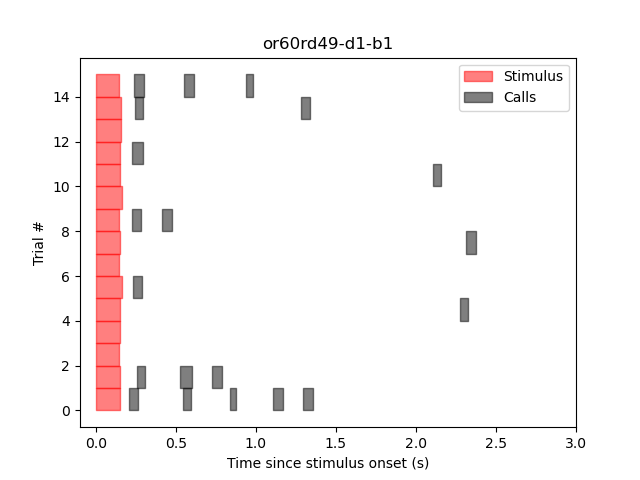

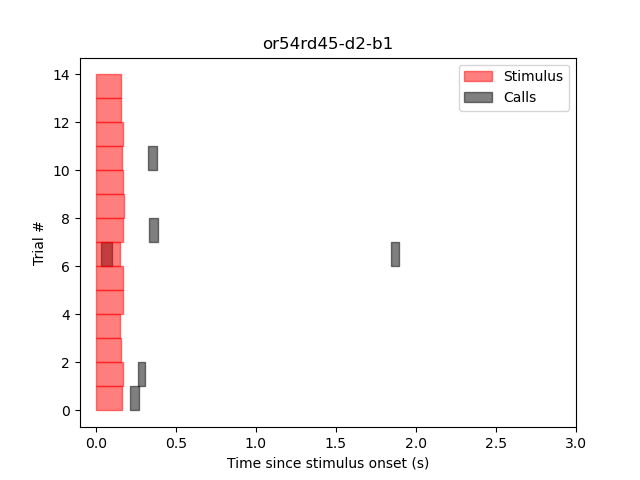

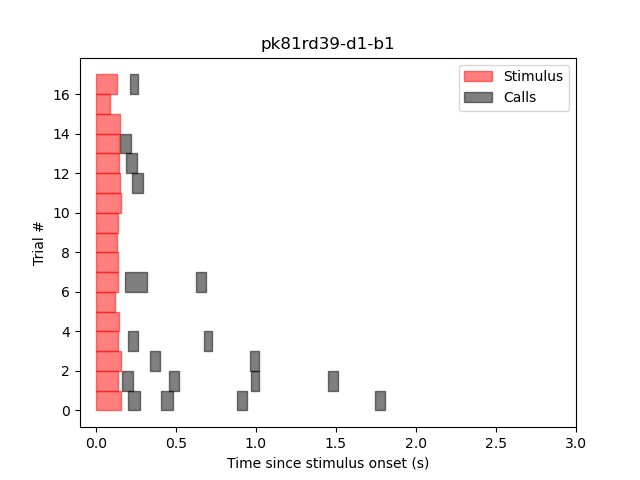

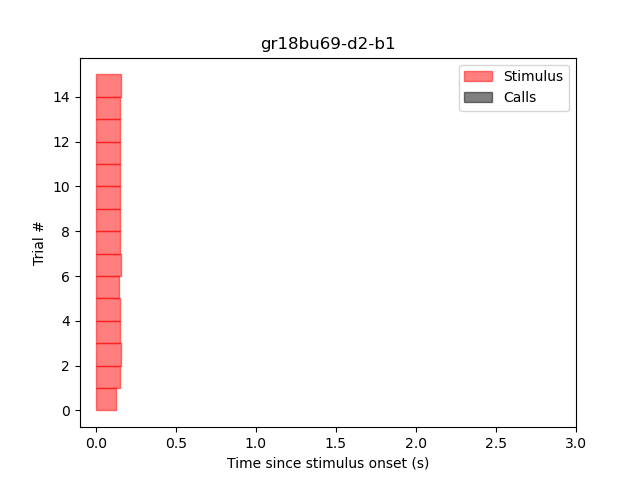

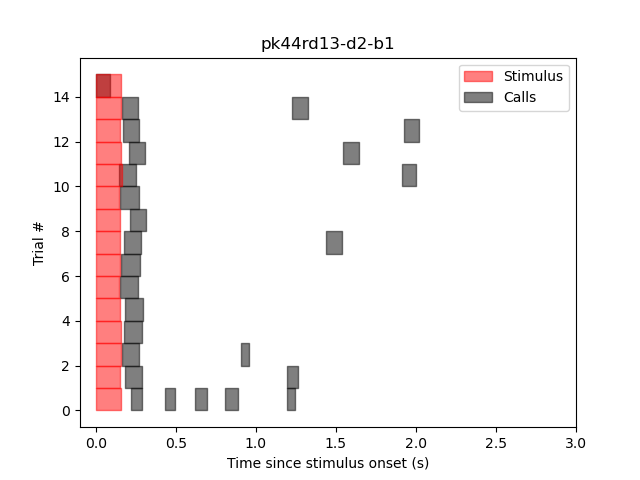

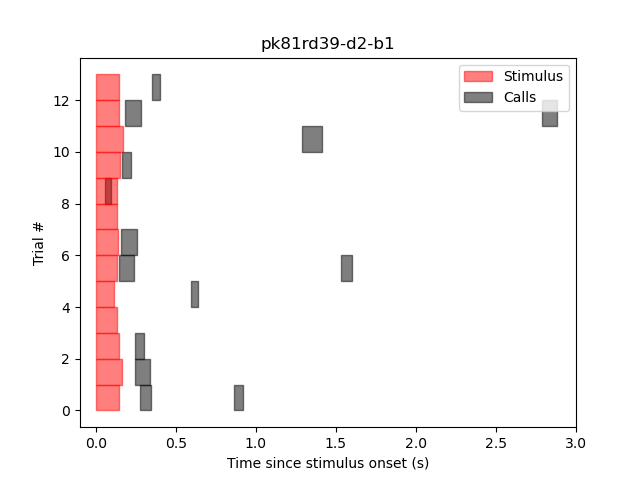

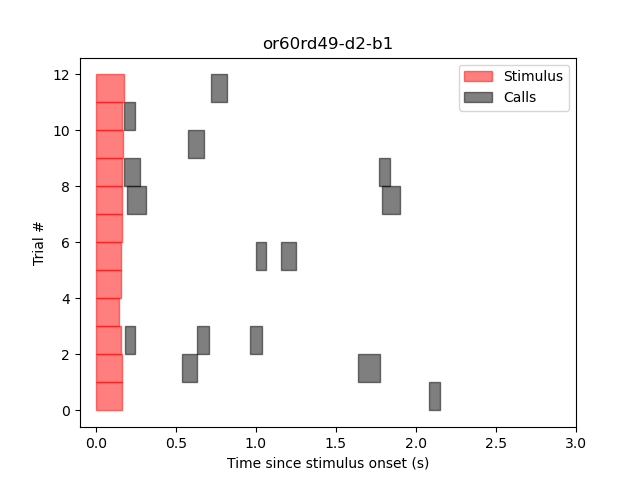

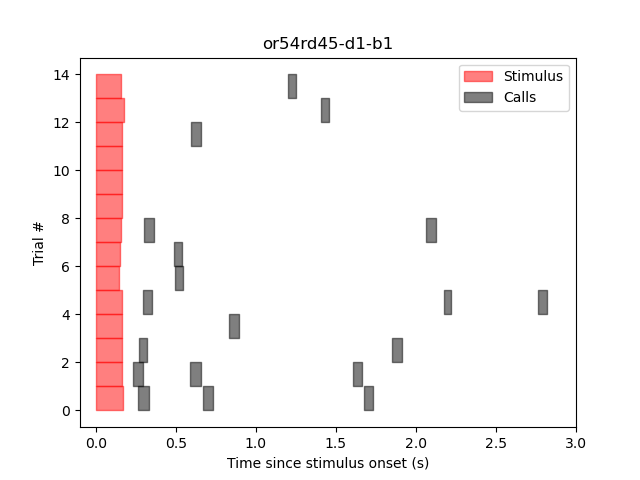

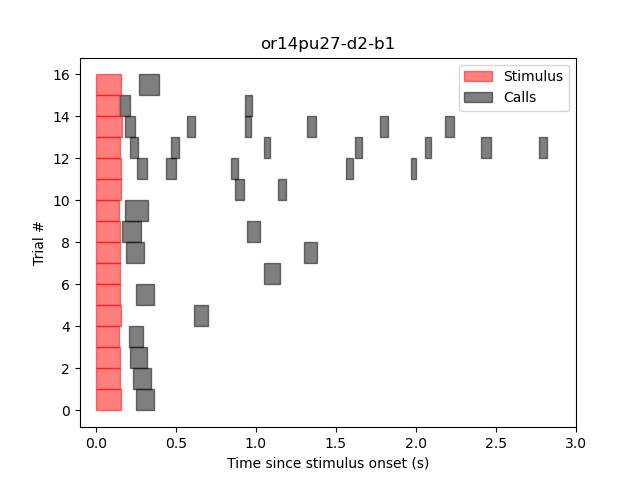

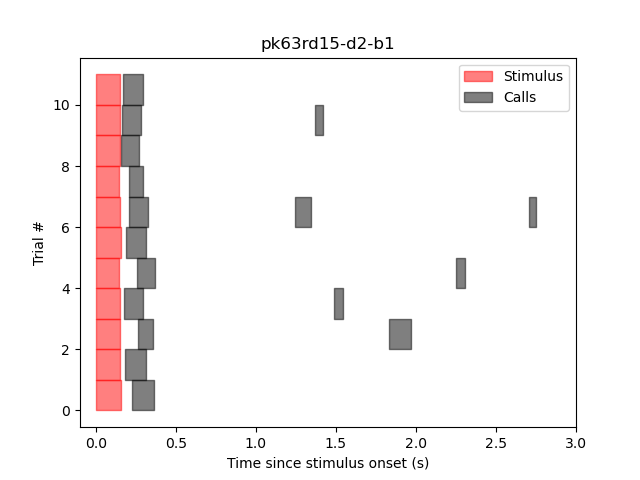

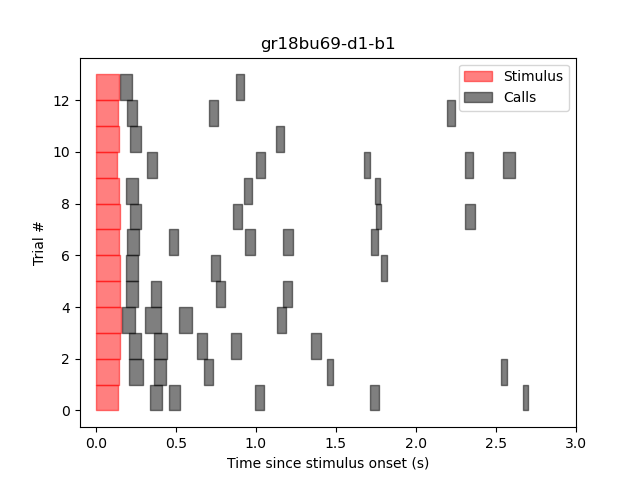

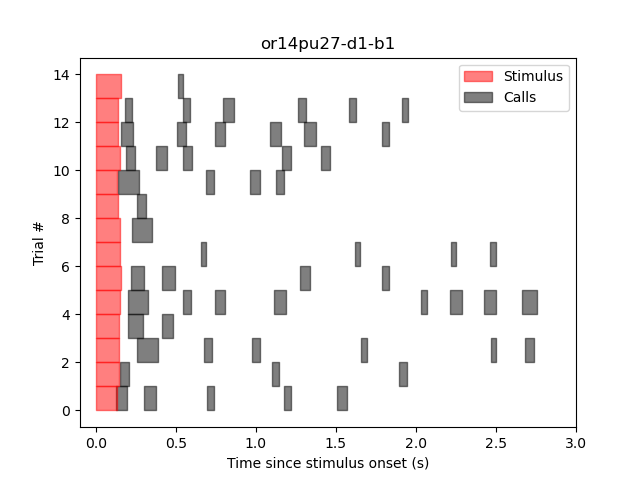

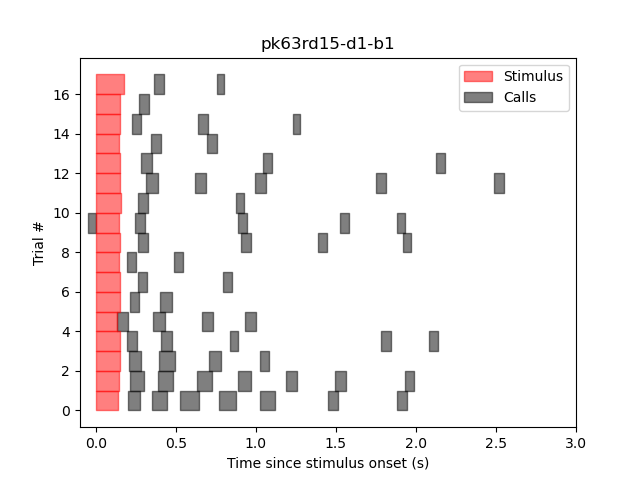

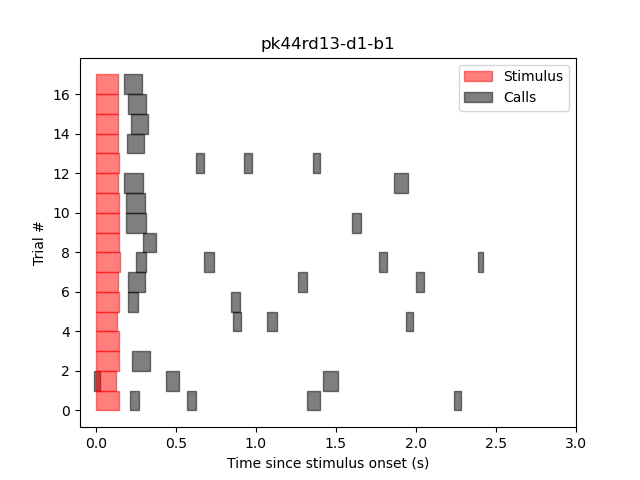

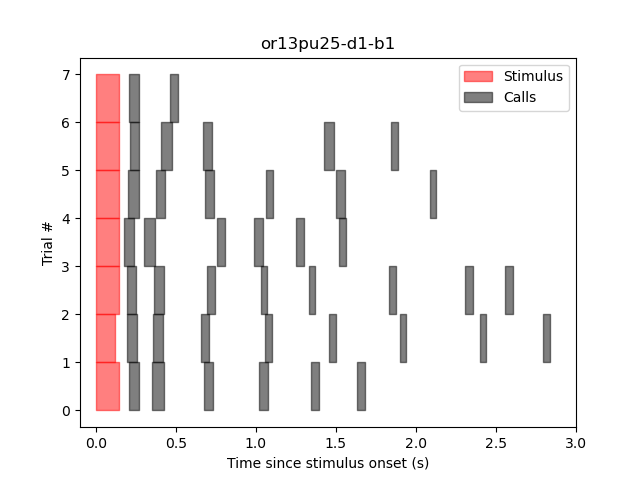

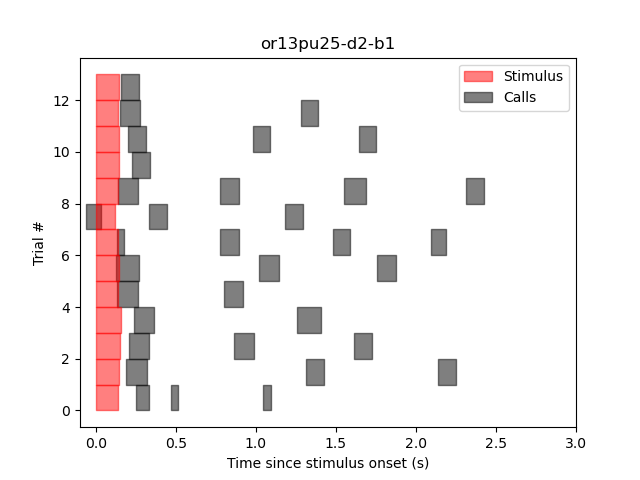

In [9]:
%aimport utils.plot
from utils.plot import plot_callback_raster


save_folder = './data/figures'

stim_kwargs = dict(color='red', alpha=0.5)
call_kwargs = dict(color='black', alpha=0.5)

unique_conditions = list(set([a[0:3] for a in df.index]))  # all in df

# unique_conditions = [
#     ('or14pu27', 1, 1),
#     ('or14pu27', 2, 1),
#     ('or54rd45', 1, 1),
#     ('or54rd45', 2, 1),
# ]

figs = {}

for bird, day, block in unique_conditions:

    fig = plt.figure()
    ax = fig.subplots()

    data = df.loc[(bird, day, block)]
    
    title_str = f'{bird}-d{day}-b{block}'

    plot_callback_raster(
        data,
        ax=ax,
        title = title_str,
        plot_stims = True,
        show_legend = True,
        call_kwargs = call_kwargs,
        stim_kwargs = stim_kwargs,
    )

    ax.set_xlim([-0.1, 3])

    figs[title_str] = fig

    fig.savefig(f'{save_folder}/{title_str}.png')